## Machine Learning Assignment 1

## **1. Import Libraries**

In [8]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import linear_model, ensemble, neighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor


## **2. About the Data**

https://www.kaggle.com/competitions/ml-for-oceanography/overview

Predict significant wave height using the NDBC (National Data Buoy Center) dataset.

**2a. Reading Data** 

           ID   #YY  MM  DD  hh  mm  WDIR(degT)  WSPD(m/s)  GST(m/s)  \
0  2017424150  2017   4  24   1  50          23        3.0       3.6   
1  2017424250  2017   4  24   2  50          30        2.9       3.3   
2  2017424350  2017   4  24   3  50         360        2.2       2.5   
3  2017424450  2017   4  24   4  50         355        2.5       3.1   
4  2017424550  2017   4  24   5  50         355        3.5       4.5   

   DPD(sec)  APD(sec)  MWD(degT)  PRES(hPa)  ATMP(degC)  WTMP(degC)  \
0      4.17      3.33        349     1019.1         4.7         5.1   
1      5.26      4.21        358     1018.8         4.6         4.8   
2      5.88      4.79         11     1018.3         4.6         4.7   
3      5.88      4.95         23     1018.1         4.6         4.6   
4      6.25      4.98         26     1018.3         4.5         4.6   

   DEWP(degC)  WVHT(m)  
0         4.2     0.39  
1         4.1     0.65  
2         4.2     0.90  
3         4.2     0.91  
4         4.0  

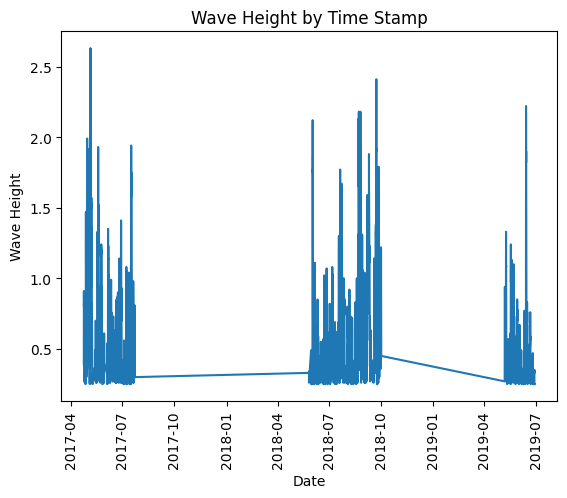

In [9]:
def read_data(datafile):

    data = pd.read_csv(datafile, delimiter=',')
    print(data.head())
    print(data.describe())
    print(data.info())
    data['date'] = (data['#YY'].astype(str) + '-' + data['MM'].astype(str).str.zfill(2)+ '-' + data['DD'].astype(str).str.zfill(2) + ' ' + 
                    data['hh'].astype(str).str.zfill(2) + ':' + data['mm'].astype(str).str.zfill(2))
    data['date'] = pd.to_datetime(data['date'], format= "%Y-%m-%d %H:%M")
    data = data.sort_values('date', ascending=True)
    plotraw(data)
    y = data['WVHT(m)']
    data = data.drop('WVHT(m)', axis=1)
    # Drop the feilds that are not parameters in definining the Signifcant Wave height
    data = data.drop('ID', axis=1)
    data = data.drop('#YY', axis=1)
    data = data.drop('MM', axis=1)
    data = data.drop('DD', axis=1)
    data = data.drop('hh', axis=1)
    data = data.drop('mm', axis=1)
    #data = data.drop('date', axis=1)
    data = pd.get_dummies(data)
    return data,  y

def plotraw(data):
    plt.plot(data['date'], data['WVHT(m)'])
    plt.ylabel('Wave Height')
    plt.xlabel('Date')
    plt.xticks(rotation=90)
    plt.title('Wave Height by Time Stamp')
    plt.show()

datafile = r"train.csv"
data, y, = read_data(datafile)


**2b. Correlation, VIF, and plotting the variables with repect to eachother**



      feature         VIF
0  WDIR(degT)    3.691799
1   WSPD(m/s)  281.739708
2    GST(m/s)  285.117771
3    DPD(sec)  102.727049
4    APD(sec)  238.848507
5   MWD(degT)    3.226752
6   PRES(hPa)   79.118515
7  ATMP(degC)  227.154939
8  WTMP(degC)   80.130395
9  DEWP(degC)   57.405548


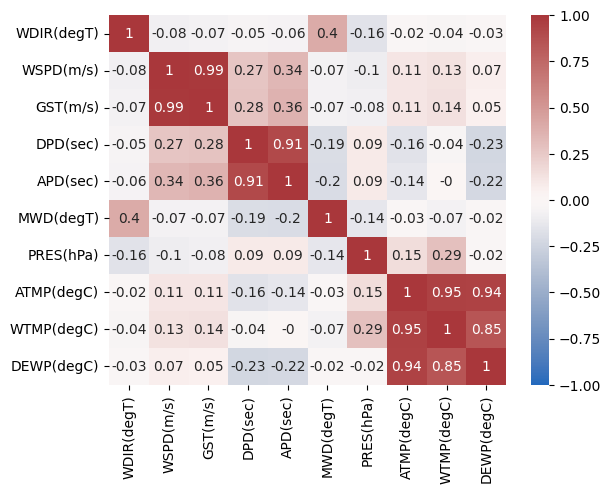

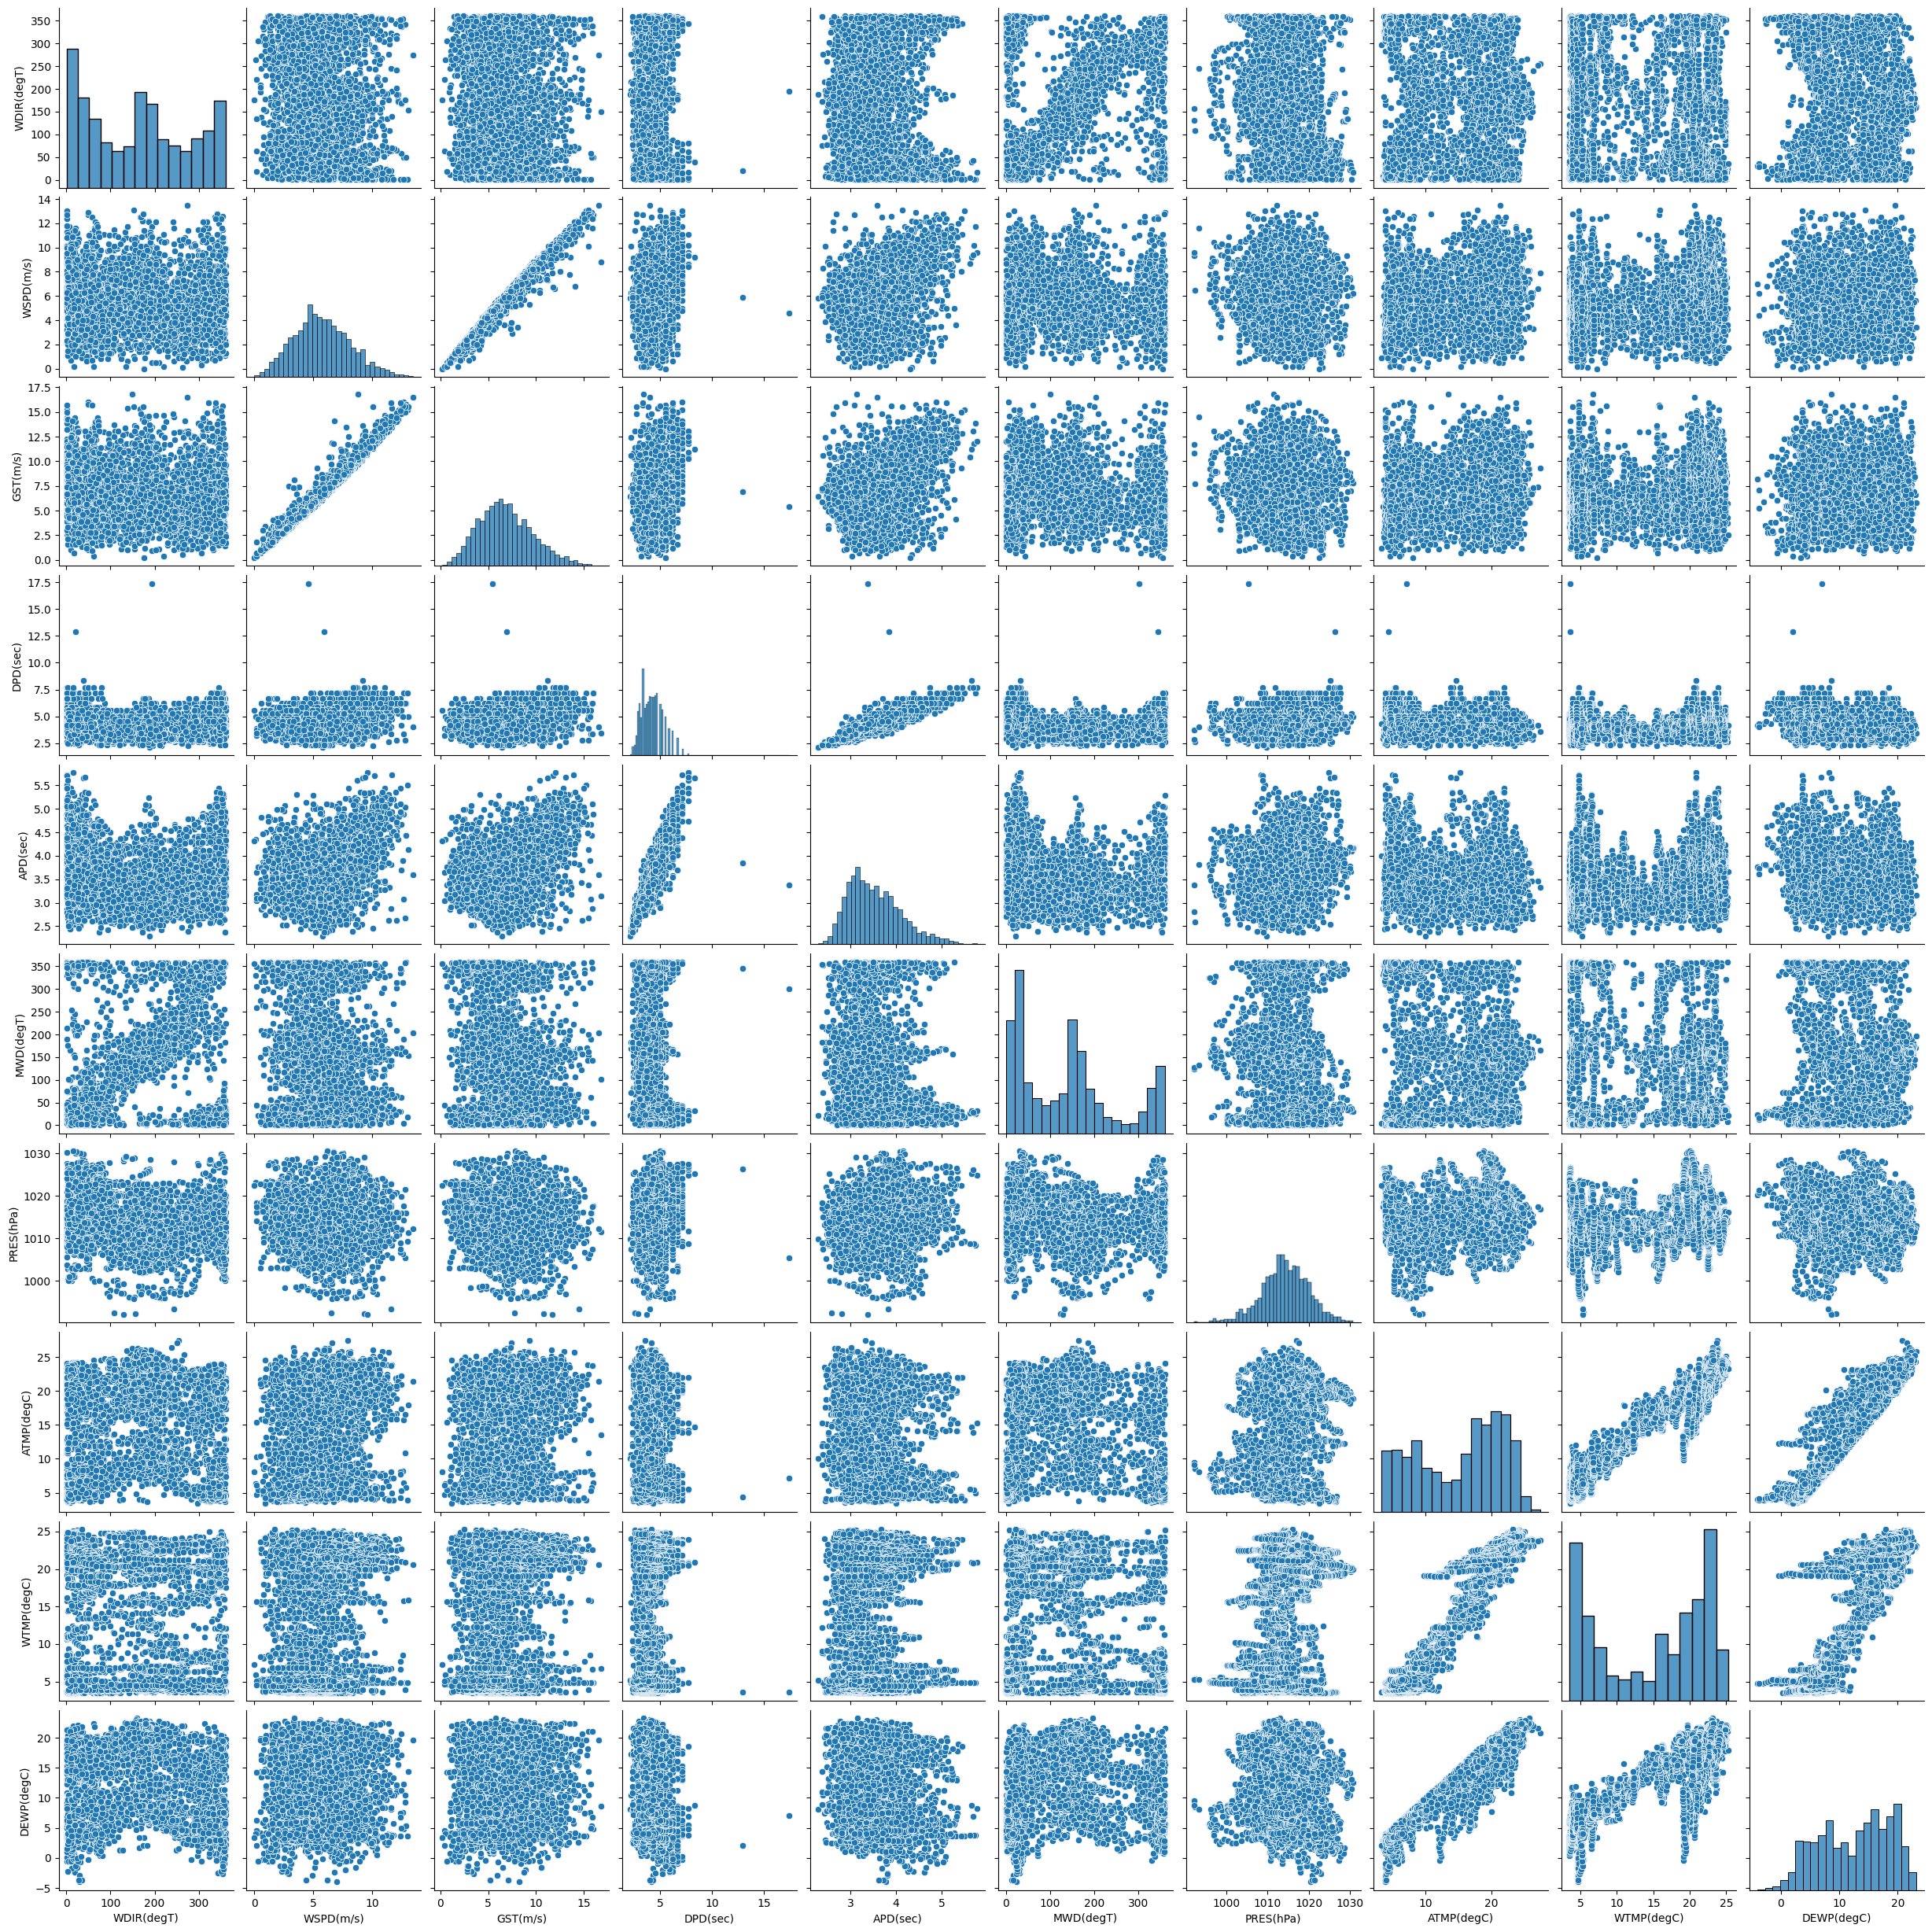

In [10]:
def corrolation(data):
    data = data.drop('date', axis=1)
    corr = data.corr().round(2)
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    return corr, vif_data

def plotcorr(corr, data):
    data = data.drop('date', axis=1)
    matrix = corr
    sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
    sns.pairplot(data=data)
    plt.show()

corr = corrolation(data)[0]
print(corrolation(data)[1])
plotcorr(corr, data)


## **3. Model Selection, Setup and Training**

1. *The Wave data is a timeseries dataset therefore it is does not satify the requirement for a classification problem. The Machine Learnign Model used for this data must be "regression" type.*

**Linear Regression Characteristics**
- Supervised learning algorithm
- Computes linear relationships between a dependent variable and one or more independent variables 
- The basic concept of linear regression is to fit a best fit line between the data points (variables) in the simplest form linearly in the form slope of a line y = mx + b.
- 2 Types
	- Simple 
        - following the equation y=mx+b
        - Where:
        - y = dependent variable (target)
        - m = slope
        - x = independent variable (predictor)
        - b = y-intercept

	- Multivariable
        - following the equation y=β0+β1X1+β2X2+⋯……βnXn
        - Where:
        - y = dependent variable
        - βn = slope of variable
        - Xn = Variable n
        - β0 = intercept

- Assumptions for Linear Regression:
	- Linearity -The independent variables have a linear relationship
	- Independence- the variables are independent to one another
	- Homoscedasticity- the variance of errors is constant
	- Normality- The residuals are normally distributed

- Additional Assumptions for Multiple Linear Regression
	- No multicollinearity – The collinearity between the variables should be minimum
	- Additivity- Assumes that the interaction between independent variables has no effect on the dependent variable 
	- Feature Selection – Removing the irrelevant or redundant variables
	- Overfitting- Fitting the model to closely 


**K Nearest Neighbors (KNN) Characteristics**

- Supervised learning algorithm
- The example below illustrates how a data point is compared to the k nearest neighbors in this case 7 and set to a determined supervised class. The data point in this example is closest to yes so it is given a classification of "Yes", because there is closest points that fall under the "Yes" classification. For a regression problem the regression problem the average of the target values of the K nearest neighbors is computed and the prediction becomes this value.

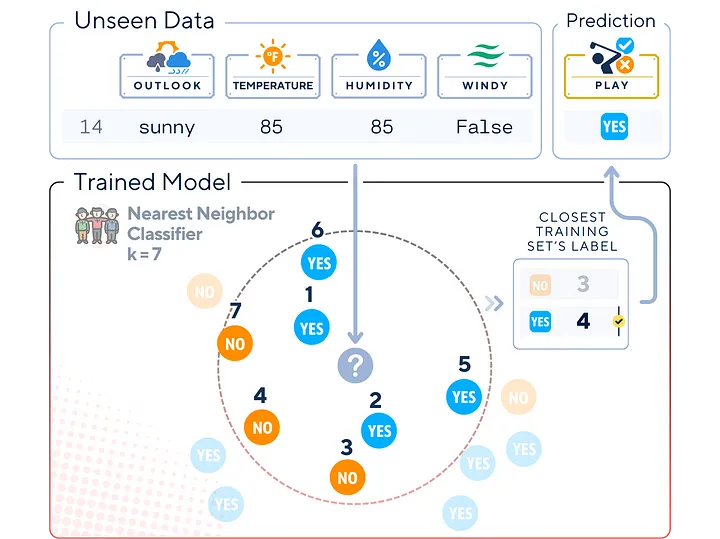
- No assumptions of Data required
- Distance Metrics 
	- Euclidean Distance
	- Manahattan Distance
	- Minkowski Distance
	- Hamming Distance
- Defining k is important in the algorithm. It is recommended that the value be odd to avoid ties to classification. 
- Simple Algorithm with few parameters, easily adapted and easy to implement. 

- Limitations
	- Requires lots of computing power and data storage due to the calculation of distances 
	- If the dimensionally to many variables KNN can struggle to classify correctly
	- Can also be affected by overfitting

In [11]:
def modelparameters(data):
    X = data
    X_train, X_test, y_train, y_test = train_test_split(X, y,  train_size=.30, random_state=42)
    return X_train, X_test, y_train, y_test

def model(user_model, X_train, y_train):
    if user_model == '1':
        print("User Selected 1 Linear Regression")
        clf = linear_model.LinearRegression() #(positive=False, n_jobs=None, fit_intercept=False, copy_X=True)
    elif user_model == '2':
        print("User Selected 2 K Nearest Neighbor Regressor")
        clf = neighbors.KNeighborsRegressor(weights='distance', n_neighbors=11, metric='manhattan')
    elif user_model == '3':
        print("User Selected 3 Random Forest Regressor")
        clf = ensemble.RandomForestRegressor() #(n_estimators=150, max_leaf_nodes=9, max_features='sqrt', max_depth=9)
    cm = clf.fit(X_train, y_train)
    return clf, cm

v_input = False
user_model = input("Please provide a 1 to run Linear Regression, 2 for K Nearest Neighbors Regression, or 3 for Ramdom Forest Regression: ")
while v_input !=True:
    if (user_model == '2') or (user_model == '1') or (user_model == '3'):
          v_input = True
    else:
        user_model = input("Not valid Input. g\nPlease provide a 1 to run Linear Regression or a 2 for Decision Tree: ")

X_train_date, X_test_date, y_train, y_test = modelparameters(data)
X_test = X_test_date.drop('date', axis=1)
X_train = X_train_date.drop('date', axis=1)
clf, cm =  model(user_model, X_train, y_train)

User Selected 1 Linear Regression


## **4. Run Prediction of Wave Height on Test Data**

In [12]:
def testmodel(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    result = pd.DataFrame({'Actual' : y_test, 'Predicted' : y_pred})
    result['diff'] = result['Actual'] - result['Predicted']
    return y_pred, result

y_pred = testmodel(clf, X_test, y_test)[0]
df = testmodel(clf, X_test, y_test)
df

(array([0.84324161, 0.2003347 , 0.08189582, ..., 1.22514439, 0.58320175,
        0.57823254]),
       Actual  Predicted      diff
 1344    0.72   0.843242 -0.123242
 2887    0.28   0.200335  0.079665
 3592    0.26   0.081896  0.178104
 3617    0.35   0.311922  0.038078
 1813    0.65   0.652041 -0.002041
 ...      ...        ...       ...
 3722    0.87   0.911732 -0.041732
 3156    0.94   0.931449  0.008551
 2794    1.36   1.225144  0.134856
 375     0.52   0.583202 -0.063202
 1908    0.59   0.578233  0.011767
 
 [2721 rows x 3 columns])

## **5. Evalualtion of Model**

1. Mean Squared Error(MSE) measures the difference between the predicted with the actual. This function is iterated and updated using the calculated gradient decent from each MSE to reach the global minima. The best fit line is the line that minimizes the overall square differences, which represents the relationship of the data. 

2. Mean Absolute Error (MAE) measures the absolute differences between the actual values with the predicted. Since this is an absolute error it is less sensitive to outliers.

3. Root Mean Square Error (RMSE) measures how well the observed data match the expected. In our case the fit to the actual and the predicted.

4. R-Squared Score R2 is the measure of how close the data points fit the model line. 1 being a prefect fit. This can be thought of the equivalent to the accuray score of the model. 


In [13]:
def accuracy_model(X_test, y_test, y_pred, clf):
    # accuracy
    accuracy = clf.score(X_test, y_test)
    print(f"Accuracy: {accuracy:.3f}")
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    rmse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)
    rss = np.sum(np.square(y_test-y_pred))
    r2score = r2_score(y_test, y_pred)

    print("MAE:", round(mae, 2))
    print("MSE:", round(mse, 2))
    print("RMSE:", round(rmse, 2))
    print("Sum of the Squares:", round(rss, 3))
    print("R2 Score:", round(r2score, 3))

accuracy_model(X_test, y_test, y_pred, clf)

Accuracy: 0.897
MAE: 0.09
MSE: 0.01
RMSE: 0.12
Sum of the Squares: 38.656
R2 Score: 0.897


## **6. Tunning HyperParameters via Random Search**

In [14]:
def randomsearch(user_model, clf):
    if user_model == '1':
        param_dist = {
        'copy_X': [True,False], 
        'fit_intercept': [True,False], 
        'n_jobs': [1,5,10,15,None], 
        'positive': [True,False]
        }
    elif user_model == '2':
        param_dist = {
        'n_neighbors' : [5,7,9,11,13,15],
        'weights' : ['uniform','distance'],
        'metric' : ['minkowski','euclidean','manhattan']
        }
    elif user_model == '3':
        param_dist = {
        'n_estimators': [25, 50, 100, 150], 
        'max_features': ['sqrt', 'log2', None], 
        'max_depth': [3, 6, 9], 
        'max_leaf_nodes': [3, 6, 9],
        }
        
    # do randomized search
    random_search = RandomizedSearchCV(estimator=clf,
    param_distributions=param_dist, random_state=42)
    random_search.fit(X_train, y_train)
    return("Best parameters from Randomized Search:", random_search.best_params_)

randomsearch(user_model, clf)

('Best parameters from Randomized Search:',
 {'positive': False, 'n_jobs': None, 'fit_intercept': False, 'copy_X': True})

# 7. References:

Baladram, S. (2024, August 19). K Nearest Neighbor Classifier, Explained: A Visual Guide with Code Examples for Beginners. Geeks for Geeks. Retrieved November 4, 2024, from https://towardsdatascience.com/k-nearest-neighbor-classifier-explained-a-visual-guide-with-code-examples-for-beginners-a3d85cad00e1

(2024, April 16). How to tune a Decision Tree in Hyperparameter tuning. GeeksforGeeks. Retrieved November 4, 2024, from https://www.geeksforgeeks.org/how-to-tune-a-decision-tree-in-hyperparameter-tuning/

(2024, May 22). Python | Linear Regression using sklearn. Geeks for Geeks. Retrieved November 4, 2024, from https://www.geeksforgeeks.org/python-linear-regression-using-sklearn/

(2024, June 15). K-Nearest Neighbor(KNN) Algorithm. GeeksforGeeks. Retrieved November 4, 2024, from https://www.geeksforgeeks.org/k-nearest-neighbours/

(2024, June 17). K-Nearest Neighbors (KNN) Regression with Scikit-Learn. Geeks for Geeks. Retrieved November 4, 2024, from https://www.geeksforgeeks.org/k-nearest-neighbors-knn-regression-with-scikit-learn/

(2024, October 14). Detecting Multicollinearity with VIF – Python. GeeksforGeeks. Retrieved November 4, 2024, from https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

(2024, October 23). Linear Regression in Machine learning. GeeksforGeeks. Retrieved November 4, 2024, from https://www.geeksforgeeks.org/ml-linear-regression/#what-is-linear-regression

(n.d.). How to tune a Decision Tree in Hyperparameter tuning. IBM. Retrieved November 4, 2024, from https://www.ibm.com/topics/linear-regression

(n.d.). What is the KNN algorithm? IBM. Retrieved November 4, 2024, from https://www.ibm.com/topics/knn